#### Imports

In [563]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ps

#### Preparing dataset for ML model

In [564]:
linkedin = pd.read_csv('../data/linkedin_standarized.csv')
linkedin.sample(5)

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size
501,3776787440,Data Engineer,Dice,WA,230000.0,En remoto,Jornada completa,Intermedio,L
123,3758102716,Machine Learning Engineer,Storm3,Estados Unidos,300000.0,Híbrido,Jornada completa,Intermedio,M
454,3775644206,Data Analyst,Suffolk Construction,MA,NaN,En remoto,Media jornada,Algo de responsabilidad,L
435,3775200323,Data Analyst,Probar Premium gratis,MA,105600.0,En remoto,Media jornada,NaN,NaN
391,3773397795,Data Analyst,Promise,VA,220800.0,En remoto,Contrato por obra,Intermedio,M


In [565]:
linkedin.shape

(518, 9)

Rename salary_range column to salary

In [566]:
linkedin.rename(columns={'salary_range': 'salary'}, inplace=True)

First we need to see which columns have null values.

In [567]:
linkedin.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
salary              57
remote_ratio         5
employment_type      0
experience_level     3
company_size         5
dtype: int64

The ones with salary range in null value, are going to be the predicted ones.

In [568]:
to_predict = linkedin[linkedin['salary'].isnull()]
to_predict.shape

(57, 9)

In [569]:
linkedin = linkedin[~linkedin['salary'].isnull()]
linkedin.shape

(461, 9)

'company_name' and 'company_state' columns are not necessary, so let's remove them.

In [570]:
linkedin = linkedin.drop(columns=['company_name', 'company_state'])
linkedin.sample()

,job_id,job_title,salary,remote_ratio,employment_type,experience_level,company_size
389,3773392703,Data Scientist,235200.0,Híbrido,Contrato por obra,Intermedio,L


Let's check again null values in order to delete those rows.

In [571]:
linkedin.isna().sum()

job_id              0
job_title           0
salary              0
remote_ratio        2
employment_type     0
experience_level    3
company_size        4
dtype: int64

In [572]:
linkedin = linkedin[linkedin[['remote_ratio']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['experience_level']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['company_size']].notna().any(axis=1)]
linkedin.shape

(453, 7)

##### Function to clean both datasets

In [573]:
def prepare_dataset(df):
    df = df.drop(columns=['company_name', 'company_state'])
    df = df[df[['remote_ratio']].notna().any(axis=1)]
    df = df[df[['experience_level']].notna().any(axis=1)]
    df = df[df[['company_size']].notna().any(axis=1)]
    return df

In [574]:
to_predict = prepare_dataset(to_predict)
to_predict.shape

(53, 7)

    Column 'job_title'

Classificating the job_title category with numbers.

In [575]:
linkedin.groupby('job_title')['salary'].mean().reset_index().sort_values(by='salary', ascending=False)

,job_title,salary
7,Deep Learning Engineer,282330.636364
8,Machine Learning Engineer,251607.409524
9,Research Engineer,241666.666667
1,BI Analyst,236500.000000
6,Data Scientist,204863.407767
5,Data Engineer,197175.201835
4,Data Analyst,167680.064220
3,Business Analyst,138750.000000
0,AI Engineer,134504.166667
2,BI Engineer,110000.000000


    Column 'remote_ratio'

In [576]:
linkedin['remote_ratio'].value_counts()

remote_ratio
En remoto     205
Híbrido       149
Presencial     99
Name: count, dtype: int64

    Column 'employment_type'

In [577]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     359
Contrato por obra     79
Prácticas             15
Name: count, dtype: int64

    Column 'experience_level'

In [578]:
linkedin['experience_level'].value_counts()

experience_level
Intermedio                 247
Sin experiencia            109
Algo de responsabilidad     54
Prácticas                   24
Director                    17
Ejecutivo                    2
Name: count, dtype: int64

    Column 'company_size'

In [579]:
linkedin['company_size'].value_counts()

company_size
L    288
M    150
S     15
Name: count, dtype: int64

#### Cleaning function

In [580]:
def categorizing_dataset(dframe):
    # ------ Cleaning: group
    df = dframe.copy()

    # 1. job_title
    job_categories = {
        'Deep Learning Engineer': 10,
        'Machine Learning Engineer': 9,
        'Research Engineer': 8,
        'BI Analyst': 7,
        'Data Scientist': 6,
        'Data Engineer': 5,
        'Data Analyst': 4,
        'Business Analyst': 3,
        'AI Engineer': 2,
        'BI Engineer': 1
    }
    df["job_title"] = df.job_title.replace(job_categories)

    # 2. remote_ratio
    remote_categories = {
        'En remoto': 100,
        'Híbrido': 50,
        'Presencial': 0
    }
    df["remote_ratio"] = df.remote_ratio.replace(remote_categories)

    # 3. employment_type
    oneonehotencoder = ps.OneHotEncoder()
    df[['Jornada completa', 'Contrato por obra', 'Prácticas']] = oneonehotencoder.fit_transform(df["employment_type"].values.reshape(-1, 1)).toarray()

    # 4. experience_level
    experience_categories = {
        'Director': 3,
        'Ejecutivo': 3,
        'Algo de responsabilidad': 2,
        'Intermedio': 2,
        'Sin experiencia': 1,
        'Prácticas': 0
    }
    df["experience_level"] = df.experience_level.replace(experience_categories)

    # 5. company_size
    df[['L', 'M', 'S']] = oneonehotencoder.fit_transform(df["company_size"].values.reshape(-1, 1)).toarray()

    return df.select_dtypes(exclude='object')

In [581]:
prepared_linkedin = categorizing_dataset(linkedin)
prepared_linkedin.sample(5)

,job_id,job_title,salary,remote_ratio,experience_level,Jornada completa,Contrato por obra,Prácticas,L,M,S
10,3635061497,9,449600.0,50,1,0.0,1.0,0.0,1.0,0.0,0.0
272,3767595033,4,139200.0,0,0,0.0,0.0,1.0,1.0,0.0,0.0
169,3761816473,4,225000.0,50,2,0.0,1.0,0.0,1.0,0.0,0.0
314,3769582747,6,195000.0,50,2,0.0,1.0,0.0,1.0,0.0,0.0
39,3728050026,9,230000.0,0,1,0.0,1.0,0.0,1.0,0.0,0.0


In [582]:
prepared_to_predict = categorizing_dataset(to_predict)
prepared_to_predict.sample()

,job_id,job_title,salary,remote_ratio,experience_level,Jornada completa,Contrato por obra,Prácticas,L,M,S
217,3764783034,5,NaN,0,0,0.0,0.0,1.0,0.0,1.0,0.0


In [583]:
# Viz mantra
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from sklearn import metrics

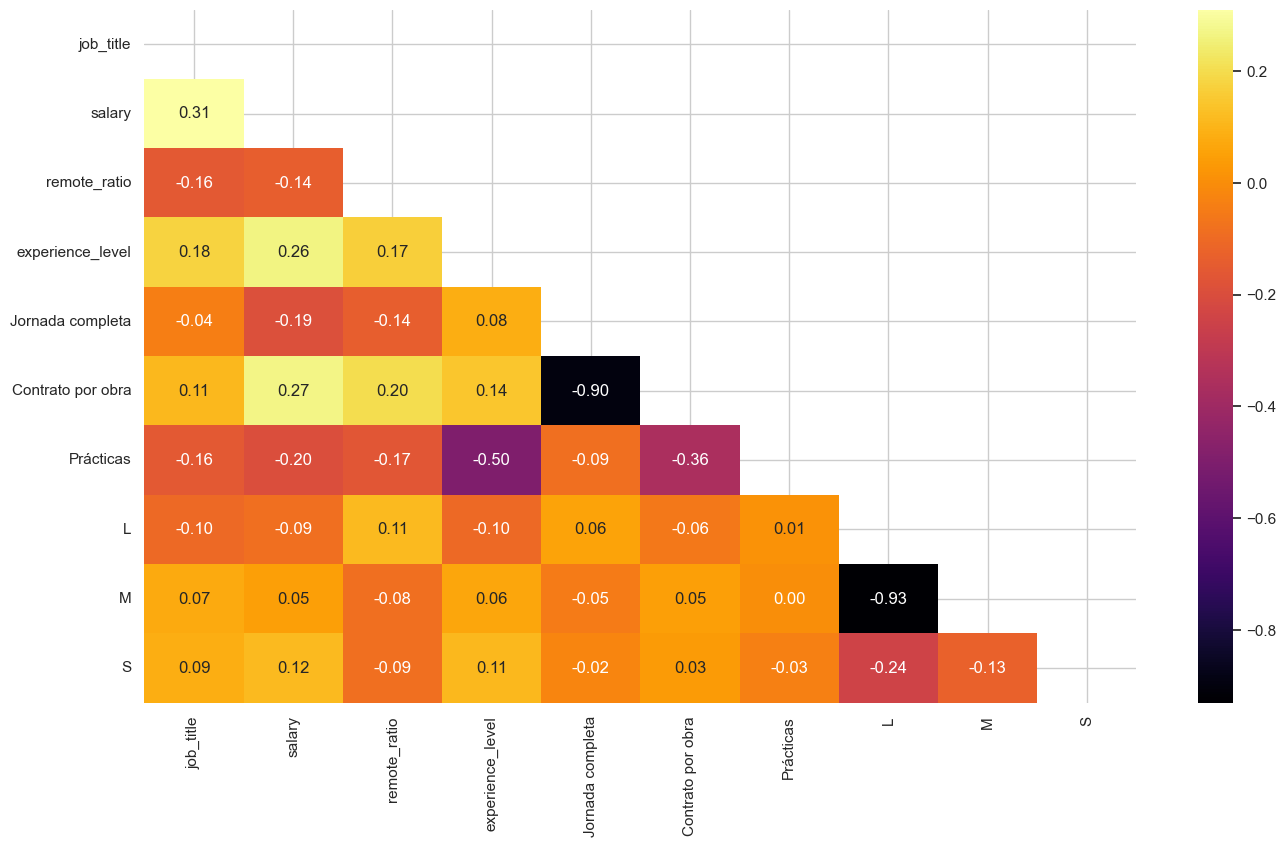

In [584]:
corr = prepared_linkedin.drop(columns=['job_id']).corr()
sns.heatmap(corr, annot=True, cmap='inferno', fmt='.2f', mask=np.triu(corr));

#### Models

In [585]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBClassifier

In [586]:
X = prepared_linkedin.drop(columns=['job_title', 'salary'])
y = prepared_linkedin['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

    LinearRegression

In [587]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [588]:
y_pred = regressor.predict(X_test)

In [589]:
metrics.r2_score(y_test, y_pred)

0.1749404923939336

    DecisionTreeRegressor

In [590]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [591]:
y_pred = regressor.predict(X_test)

In [592]:
metrics.r2_score(y_test, y_pred)

0.4384019144968818

    KNeighborsRegressor

In [593]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [594]:
y_pred = regressor.predict(X_test)

In [595]:
metrics.r2_score(y_test, y_pred)

0.4830334158751831

    GradientBoostingRegressor

In [596]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [597]:
y_pred = regressor.predict(X_test)

In [598]:
metrics.r2_score(y_test, y_pred)

0.4338151455861252

    RandomForestRegressor

In [599]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [600]:
y_pred = regressor.predict(X_test)

In [601]:
metrics.r2_score(y_test, y_pred)

0.7101012985339328

#### TESTS with X_test

In [610]:
X_test_copy = X_test.copy()
X_test_copy['salary'] = y_pred
X_test_copy['salary_real'] = y_test
X_test_copy.sample(5)

,job_id,remote_ratio,experience_level,Jornada completa,Contrato por obra,Prácticas,L,M,S,salary,salary_real
81,3749774586,50,2,0.0,1.0,0.0,0.0,1.0,0.0,217438.24,217000.0
142,3759962208,0,2,1.0,0.0,0.0,0.0,1.0,0.0,186194.80,180480.0
409,3773897548,100,1,0.0,1.0,0.0,1.0,0.0,0.0,207750.00,207750.0
459,3775709388,100,2,1.0,0.0,0.0,0.0,1.0,0.0,228447.25,230400.0
362,3772664388,50,1,1.0,0.0,0.0,1.0,0.0,0.0,129806.80,92500.0


#### Prediction for those with null salary

In [602]:
prediction = regressor.predict(prepared_to_predict.drop(columns=['job_title', 'salary']))

In [603]:
to_predict.sample()

,job_id,job_title,salary,remote_ratio,employment_type,experience_level,company_size
226,3765346803,Data Analyst,NaN,Presencial,Prácticas,Prácticas,M


In [604]:
to_predict['salary'] = prediction # Adding the predicted price
to_predict

,job_id,job_title,salary,remote_ratio,employment_type,experience_level,company_size
35,3713995239,Data Analyst,248400.20,Presencial,Prácticas,Intermedio,L
57,3740964793,Data Scientist,156985.72,Presencial,Prácticas,Prácticas,L
90,3752872433,Data Scientist,77621.60,Híbrido,Prácticas,Prácticas,L
91,3753015172,Data Engineer,82066.40,Híbrido,Prácticas,Prácticas,L
92,3753408170,Deep Learning Engineer,82066.40,Híbrido,Prácticas,Prácticas,L
93,3754419732,Data Scientist,82171.20,Híbrido,Prácticas,Prácticas,M
94,3755005401,Data Engineer,96231.20,Híbrido,Prácticas,Prácticas,S
95,3755033312,Machine Learning Engineer,83016.20,Híbrido,Prácticas,Prácticas,M
96,3755047295,Data Analyst,82734.40,Híbrido,Prácticas,Prácticas,L
97,3755065806,Data Engineer,82734.40,Híbrido,Prácticas,Prácticas,L
